In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import sys
import numpy as np
from hmmlearn import hmm
import itertools
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
# Ruta al archivo CSV
csv_path = "./coffee.csv"  # Reemplaza con la ruta a tu archivo CSV

try:
    # Usa pandas para leer el archivo CSV
    used_data = pd.read_csv(csv_path)
except FileNotFoundError:
    print("Archivo CSV no encontrado. Por favor, verifica la ruta del archivo.")
    sys.exit()
    
test_size = 0.3
    
# No mezcles los datos ya que es una serie temporal
_train_data, test_data = train_test_split(used_data, test_size=test_size, shuffle=False)

# Elimina las columnas que no se usan
train_data = _train_data.drop(["Volume", "Adj Close"], axis=1)  
test_data = test_data.drop(["Volume", "Adj Close"], axis=1) 

train_data.dropna(inplace=True)

print(len(train_data))

868


In [9]:
# Parametros
n_components = 3
n_latency_days = 5
n_intervals = 15
days = len(test_data)

# Extrae las características: precios de apertura, cierre, máximo y mínimo
open_price = np.array(train_data["Open"])
close_price = np.array(train_data["Close"])
high_price = np.array(train_data["High"])
low_price = np.array(train_data["Low"])

# Calcula los cambios fraccionales en los precios alto, bajo y de cierre para usar como conjunto de observaciones
frac_change = (close_price - open_price) / open_price
frac_high = (high_price - open_price) / open_price
frac_low = (open_price - low_price) / open_price

# Apila las características en columnas
features = np.column_stack((frac_change, frac_high, frac_low))

# Inicializa el modelo HMM
hmm_1 = hmm.GMMHMM(n_components)

# Registro de la extracción de características
observations = features 

# Ajusta el modelo HMM usando la función 'fit' de hmmlearn
hmm_1.fit(observations)

# Parámetros para los intervalos
n_intervals_frac_change = n_intervals
n_intervals_frac_high = n_intervals  
n_intervals_frac_low = n_intervals

# Crea arrays de NumPy con números espaciados uniformemente para cada rango
frac_change_range = np.linspace(-0.1, 0.1, n_intervals_frac_change)
frac_high_range = np.linspace(0, 0.1, n_intervals_frac_high)
frac_low_range = np.linspace(0, 0.1, n_intervals_frac_low)

# Calcula todos los resultados posibles utilizando el producto cartesiano
possible_outcomes = np.array(
list(itertools.product(frac_change_range, frac_high_range, frac_low_range))
)

In [4]:
def predictor(n_latency_days, day_index):

    # Usa los datos anteriores de n_latency_days para las predicciones
    previous_data_start_index = max(0, day_index - n_latency_days)
    previous_data_end_index = max(0, day_index - 1)
    previous_data = test_data.iloc[previous_data_start_index:previous_data_end_index]

    outcome_score = []

    # Evalúa todos los resultados posibles y selecciona el más probable para usar en la predicción
    for possible_outcome in possible_outcomes:
        total_data = np.row_stack((features, possible_outcome))
        outcome_score.append(hmm_1.score(total_data))

    # Obtén el índice del resultado más probable y devuélvelo
    most_probable_outcome = possible_outcomes[np.argmax(outcome_score)]

    # Obtén el precio de apertura para el día dado
    open_price = test_data.iloc[day_index]["Open"]

    # Supongamos que 'most_probable_outcome' contiene los cambios fraccionales más probables en [frac_change, frac_high, frac_low]
    predicted_frac_change, pred_frac_high, pred_frac_low = most_probable_outcome

    # Calcula el precio de cierre previsto
    predicted_close_price = open_price * (1 + predicted_frac_change)

    # Obtén la fecha correspondiente al day_index
    date_at_day_index = test_data.iloc[day_index]['Date']
    
    return predicted_close_price, date_at_day_index

In [5]:
value, date = predictor(1, 33)
print(value, date)

132.31356838571426 2017-04-24


In [6]:
# Inicializa una lista vacía para almacenar los precios de cierre previstos
predicted_close_prices = []

# Imprime el rango de fechas para las que se harán las predicciones
print(
    "Predicting Close prices from "
    + str(test_data.index[0])
    + " to "
    + str(test_data.index[-1])
)

# Bucle para predecir los precios de cierre para cada día en el período de prueba
for day_index in tqdm(range(days)):
    value, date = predictor(1, day_index)
    predicted_close_prices.append(value)

Predicting Close prices from 868 to 1240


100%|█████████████████████████████████████████| 373/373 [29:23<00:00,  4.73s/it]


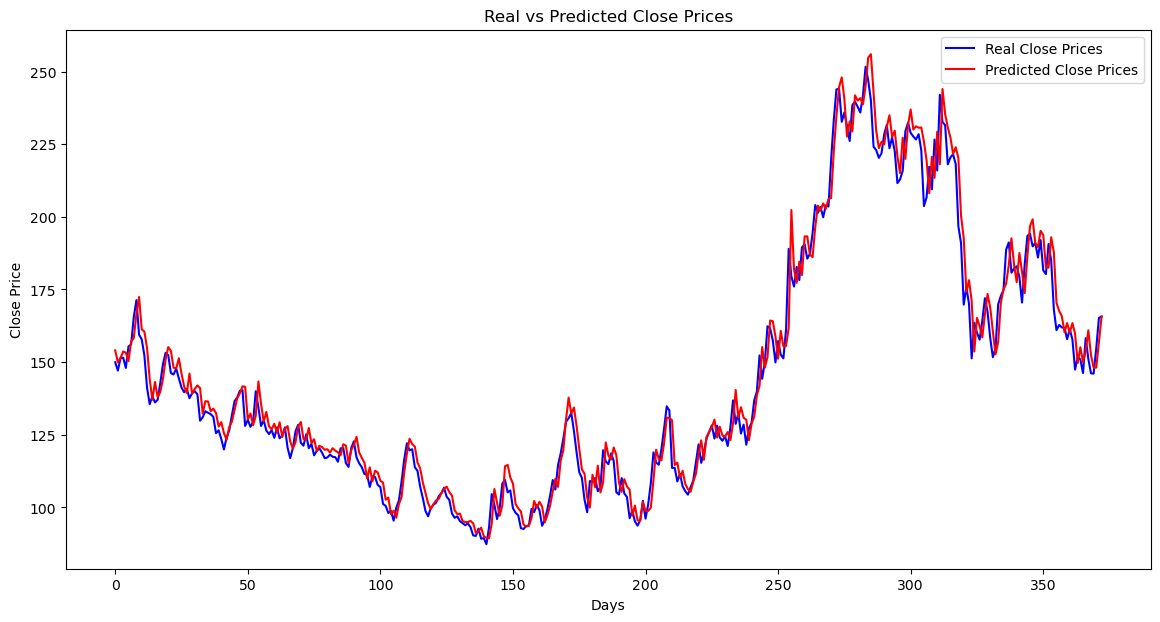

In [7]:
# Almacena y devuelve los precios de cierre reales
actual_close_prices = test_data.loc[:, ["Close"]]

# Convertir 'actual_close_prices' a una lista si es un DataFrame de pandas
if isinstance(actual_close_prices, pd.DataFrame):
    actual_close_prices = actual_close_prices["Close"].tolist()

# Crear el gráfico
plt.figure(figsize=(14, 7))

# Trazar los precios de cierre reales
plt.plot(actual_close_prices, label='Real Close Prices', color='blue')

# Trazar los precios de cierre previstos
plt.plot(predicted_close_prices, label='Predicted Close Prices', color='red')

# Añadir título y etiquetas
plt.title('Real vs Predicted Close Prices')
plt.xlabel('Days')
plt.ylabel('Close Price')
plt.legend()

# Mostrar el gráfico
plt.show()

In [8]:
error_abs = abs(np.array(actual_close_prices) - np.array(predicted_close_prices))/np.array(actual_close_prices) 
error_10days = error_abs.mean()
error_10days

0.03508835151093526